# Brain Tumor Classification with Vision Transformer (ViT)

## 1. Importing Libraries


In [8]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T

import timm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, classification_report

## 2. Dataset class for binary classification


In [ ]:
class BrainTumorClassificationDataset(Dataset):
    def __init__(self, csv_path, base_dir=r"B:\Brain\Brain_MRI", image_size=224):
        self.df = pd.read_csv(csv_path)
        self.base_dir = base_dir
        self.image_size = image_size
        self.transform = T.Compose([
            T.Resize((image_size, image_size)),
            T.ToTensor(),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.base_dir, row["image_path"])
        label = int(row["mask"])

        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

## 3. Initialize dataset and split into train/val/test

In [ ]:
full_dataset = BrainTumorClassificationDataset(r"B:\Brain\Brain_MRI\data_mask.csv")

train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

## 4. Vision Transformer model for classification

In [11]:
class ViTClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(ViTClassifier, self).__init__()
        self.backbone = timm.create_model("vit_base_patch16_224", pretrained=True)
        in_features = self.backbone.head.in_features
        self.backbone.head = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTClassifier().to(device)

## 5. Training setup


In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

## 6. Metrics function

In [13]:
def evaluate_with_metrics(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    return acc, prec, rec, f1, cm

## 7. Training Loop


In [14]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(10):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for imgs, labels in tqdm(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_size = labels.size(0)
        total_loss += loss.item() * batch_size  

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += batch_size

    train_acc = correct / total
    avg_train_loss = total_loss / total 
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            batch_size = labels.size(0)
            val_loss += loss.item() * batch_size

            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += batch_size

    val_acc = correct / total
    avg_val_loss = val_loss / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")


100%|██████████| 172/172 [03:34<00:00,  1.25s/it]


Epoch 1 | Train Loss: 0.4128 | Train Acc: 0.8127 | Val Loss: 0.1819 | Val Acc: 0.9372


100%|██████████| 172/172 [02:11<00:00,  1.31it/s]


Epoch 2 | Train Loss: 0.2023 | Train Acc: 0.9291 | Val Loss: 0.1019 | Val Acc: 0.9694


100%|██████████| 172/172 [02:29<00:00,  1.15it/s]


Epoch 3 | Train Loss: 0.1644 | Train Acc: 0.9440 | Val Loss: 0.1617 | Val Acc: 0.9457


100%|██████████| 172/172 [02:29<00:00,  1.15it/s]


Epoch 4 | Train Loss: 0.1370 | Train Acc: 0.9549 | Val Loss: 0.1278 | Val Acc: 0.9610


100%|██████████| 172/172 [1:07:37<00:00, 23.59s/it]     


Epoch 5 | Train Loss: 0.1056 | Train Acc: 0.9665 | Val Loss: 0.1146 | Val Acc: 0.9626


100%|██████████| 172/172 [02:06<00:00,  1.36it/s]


Epoch 6 | Train Loss: 0.1076 | Train Acc: 0.9651 | Val Loss: 0.0940 | Val Acc: 0.9677


100%|██████████| 172/172 [02:05<00:00,  1.37it/s]


Epoch 7 | Train Loss: 0.0828 | Train Acc: 0.9705 | Val Loss: 0.1030 | Val Acc: 0.9677


100%|██████████| 172/172 [02:01<00:00,  1.42it/s]


Epoch 8 | Train Loss: 0.0645 | Train Acc: 0.9822 | Val Loss: 0.1311 | Val Acc: 0.9559


100%|██████████| 172/172 [02:22<00:00,  1.21it/s]


Epoch 9 | Train Loss: 0.0682 | Train Acc: 0.9782 | Val Loss: 0.1022 | Val Acc: 0.9677


100%|██████████| 172/172 [1:05:02<00:00, 22.69s/it]    


Epoch 10 | Train Loss: 0.0504 | Train Acc: 0.9851 | Val Loss: 0.1749 | Val Acc: 0.9440


## 8.  Training Curve

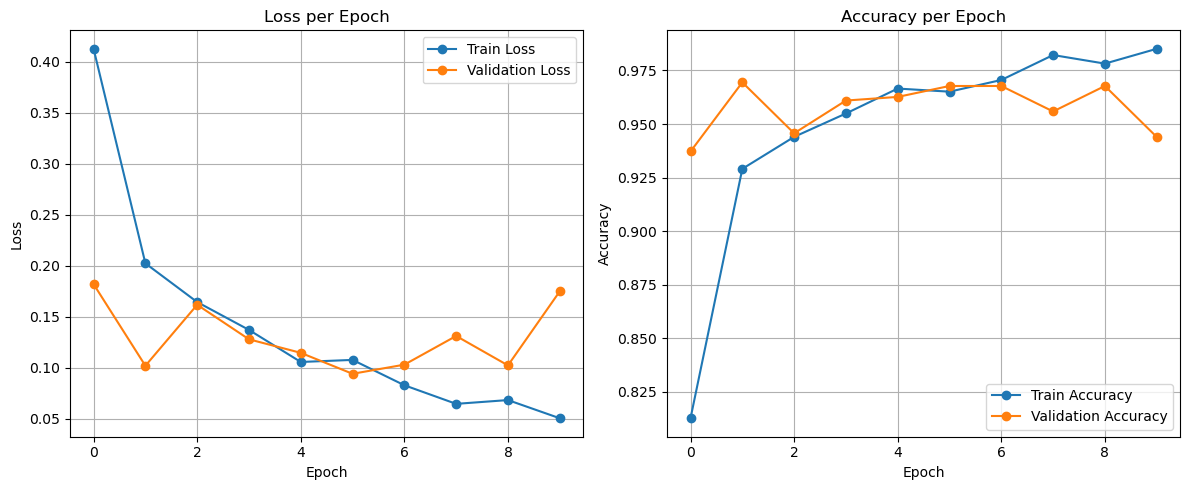

In [15]:
plt.figure(figsize=(12, 5))

# Loss Curves
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


## 9. Model Save

In [16]:
torch.save(model.state_dict(), "vit_brain_tumor.pth")
print("Model saved as vit_brain_tumor.pth")

Model saved as vit_brain_tumor.pth


## 10. Final test evaluation

In [17]:
acc, prec, rec, f1, cm = evaluate_with_metrics(model, test_loader)
print("\n Final Test Evaluation")
print(f"Accuracy : {acc:.4f}\nPrecision: {prec:.4f}\nRecall   : {rec:.4f}\nF1 Score : {f1:.4f}")
print("Confusion Matrix:\n", cm)


 Final Test Evaluation
Accuracy : 0.9407
Precision: 0.8810
Recall   : 0.9487
F1 Score : 0.9136
Confusion Matrix:
 [[370  25]
 [ 10 185]]


## 11. Visualization functions

In [18]:
def plot_confusion_matrix(cm):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Tumor", "Tumor"], yticklabels=["No Tumor", "Tumor"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

def plot_roc_curve(model, dataloader):
    model.eval()
    all_probs, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            all_probs.extend(probs)
            all_labels.extend(labels.numpy())

    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    auc = roc_auc_score(all_labels, all_probs)

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()

def print_classification_report(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    print(classification_report(all_labels, all_preds, target_names=["No Tumor", "Tumor"]))

## 12. Call the visualization functions

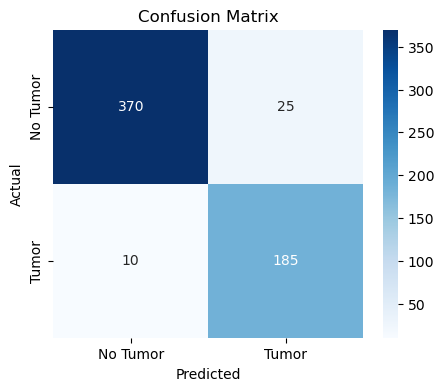

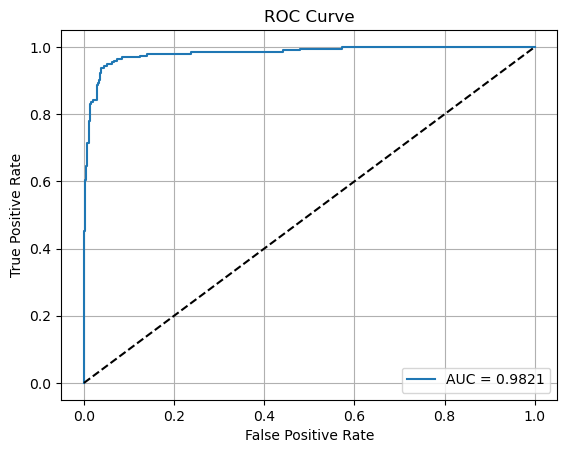

              precision    recall  f1-score   support

    No Tumor       0.97      0.94      0.95       395
       Tumor       0.88      0.95      0.91       195

    accuracy                           0.94       590
   macro avg       0.93      0.94      0.93       590
weighted avg       0.94      0.94      0.94       590



In [19]:
plot_confusion_matrix(cm)
plot_roc_curve(model, test_loader)
print_classification_report(model, test_loader)